In [17]:
from IPython.display import FileLink
gen_link = FileLink('Unconditional_Convolutional_Generator.pth')
critic_link = FileLink('critic.pth')

In [18]:
gen_link

/kaggle/working/Unconditional_Convolutional_Generator.pth

In [3]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad as torch_grad
from torch.autograd import Variable
from torchvision.datasets import MNIST
import torchvision.transforms as T
import torchvision.transforms.functional as Fvision
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [ ]:
os.mkdir('image_samples')

In [5]:
transform = T.ToTensor()
dataset_train = MNIST(root='mnist_train',train=True,transform=transform,download=True)
dataset_test = MNIST(root='mnist_test',train=False,transform=transform,download=True)
concatenated_dataset = ConcatDataset([dataset_train,dataset_test])

100%|██████████| 9912422/9912422 [00:00<00:00, 139421770.03it/s]

Extracting mnist_train/MNIST/raw/train-images-idx3-ubyte.gz to mnist_train/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 45233642.20it/s]


Extracting mnist_train/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37534144.87it/s]


Extracting mnist_train/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8470666.42it/s]


Extracting mnist_train/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 137144317.37it/s]

Extracting mnist_test/MNIST/raw/train-images-idx3-ubyte.gz to mnist_test/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 42473945.94it/s]


Extracting mnist_test/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36369758.34it/s]


Extracting mnist_test/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7852649.95it/s]

Extracting mnist_test/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_test/MNIST/raw



In [6]:
# @title Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.linear0 = nn.Sequential(
            nn.Linear(32,2048,bias=False),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU()
        )
        
        self.trans_conv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=2048,
                               out_channels=512,
                               kernel_size=(4,4),
                               stride=1
                              ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )

        self.trans_conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512,
                               out_channels=64,
                               kernel_size=(4,4),
                               stride=2,
                               padding=1
                              ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )

        self.trans_conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=32,
                               kernel_size=(4,4),
                               stride=2,
                               padding=2), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU()
        )
        
        self.trans_conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32,
                               out_channels=16,
                               kernel_size=(4,4),
                               stride=2,
                               padding=0), 
#             nn.BatchNorm2d(16),
            nn.LeakyReLU()
        )
        
        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=1,
                      kernel_size=3,
                      stride=1,
                      padding=0,
                      dilation=1),
            
        )



    def forward(self,noise):
        x = self.linear0(noise)
#         print(x.shape)
        x = x.view(x.shape[0],x.shape[1],1,1)
#         print(x.shape)
        x = self.trans_conv0(x)
#         print(x.shape)
        x = self.trans_conv1(x)
#         print(x.shape)
        x = self.trans_conv2(x)
#         print(x.shape)
        x = self.trans_conv3(x)
#         print(x.shape)
        x = self.conv0(x)
#         print(x.shape)
        return x

In [5]:
gen = Generator()
z = torch.randn(4,32)
img = gen(z)


In [7]:
# @title Critic
class Critic(nn.Module):
    def __init__(self):
        super(Critic,self).__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(1,32,5,2,2),
            nn.LayerNorm([32,14,14]),
            nn.ReLU()
        )
        self.conv1 = nn.Sequential(
            nn.Conv2d(32,512,5,2,2),
            nn.LayerNorm([512,7,7]),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(512,512,5,2,2),
            nn.LayerNorm([512,4,4]),
            nn.ReLU()
        )
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.linear0 = nn.Linear(512,1)
        
    def forward(self,img):
        x = self.conv0(img)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.avg_pool(x).flatten(1)
        out = self.linear0(x)
        return out

In [8]:
# @title training functions
def wloss(preds_real,preds_gen):
    return torch.mean(preds_gen) - torch.mean(preds_real)

def reg(critic,imgs_real,imgs_gen):
#     imgs_shape = (28,28,1)
    alpha = torch.rand(args['data']['batch_size'],1,1,1).to(args['device'])
    interpolated = alpha*imgs_real.data + (1-alpha)*imgs_gen.data
    interpolated.requires_grad = True
    pred_interpolated = critic(interpolated)
    
    gradient = torch_grad(outputs=pred_interpolated,
                          inputs=interpolated,
                          grad_outputs=torch.ones(args['data']['batch_size'],1).to(args['device']),
                          create_graph=True,
                          retain_graph=True)[0]
    
    gradient_norm = torch.sqrt(torch.sum(gradient**2,dim=(2,3))+1e-12)
    reg_value = torch.mean((gradient_norm-1)**2)
    return args['critic']['lamda']*reg_value

def generate_img(args):
    z = args['data']['constant_z'].to(args['device'])
    args['gen']['model'].eval()
    with torch.no_grad():
        img = args['gen']['model'](z).to('cpu')
    return img


# train critic by computing the gradient on interpolations
def train_critic(args,imgs_real,noises):

    args['critic']['model'].train()
    args['gen']['model'].eval()

    with torch.no_grad():
        imgs_gen = args['gen']['model'](noises)

    preds_real = args['critic']['model'](imgs_real)
    preds_gen = args['critic']['model'](imgs_gen)

    wloss_value = wloss(preds_real,preds_gen)
    reg_value = reg(args['critic']['model'],imgs_real,imgs_gen)


    loss_value = wloss_value + reg_value
    loss_value.backward()
    args['critic']['optim']['algorithm'].step()
    args['critic']['optim']['algorithm'].zero_grad()

    return loss_value.item(),wloss_value.item(),reg_value


def train_gen(args,noises):

    args['critic']['model'].eval()
    args['gen']['model'].train()
    
    imgs_gen = args['gen']['model'](noises)
    preds_gen = args['critic']['model'](imgs_gen)
    loss_value = -1*torch.mean(preds_gen)
    loss_value.backward()
    args['gen']['optim']['algorithm'].step()
    args['gen']['optim']['algorithm'].zero_grad()
    args['critic']['model'].zero_grad()
    return loss_value.item()


In [9]:
def train_epoch(args):

    num_iter = 0
    for imgs_real,_ in tqdm(loader):
        num_iter += 1

        imgs_real = imgs_real.to(args['device'])
        noises = torch.randn(args['data']['batch_size'],args['data']['z_features']).to(args['device'])

        loss_value,wloss_value,reg_value = train_critic(args,imgs_real,noises)

        if num_iter%args['critic']['ncritic'] == 0:
            loss_value = train_gen(args,noises)
    

In [10]:
def train(args):
    for epoch in range(*args['epochs']):
        
        if (epoch+1) % 10 == 0:
            print('saving generator')
            torch.save(args['gen']['model'].state_dict(),args['gen']['dir'])
            print('saving critic')
            torch.save(args['critic']['model'].state_dict(),args['critic']['dir'])
            
            print('saving generated images')
            img = generate_img(args)
            img_name = f'image_samples/generated_img_sample_epoch_{epoch}.pt'
            torch.save(img,img_name)
        
        if (epoch+1) % 30 == 0:
            print('\n schedular step')
            args['critic']['schedular'].step()
            args['gen']['schedular'].step()
        
        print(f"Epoch: {epoch+1}")
        train_epoch(args)

In [14]:
args = {
    'critic':{
        'model': None,
        'ncritic':3,
        'optim':{
            'algorithm':None,
            'lr':0.0001,
            'betas':(0.5,0.99),
        },
        'schedular':None,
        'dir':'critic.pth',
        'load':False,
        'lamda':10
    },
    'gen':{
        'model': None,
        'optim':{
            'algorithm':None,
            'lr':0.0001,
            'betas':(0.5,0.99)
        },
        'schedular':None,
        'dir':'Unconditional_Convolutional_Generator.pth',
        'load':False
    },
    'data':{
        'loader': None,
        'batch_size':512,
        'img_shape':[1,28,28],
        'z_features':32,
        'constant_z':torch.randn(16,32),
        },
    'device':'cuda',
    'epochs':(0,200)
}

In [15]:
gen = Generator().to(args['device'])
args['gen']['model'] = gen
if args['gen']['load'] == True:
    print("loading Generator's state dictionary")
    args['gen']['model'].load_state_dict(torch.load(args['gen']['dir']))
critic = Critic().to(args['device'])
args['critic']['model'] = critic
if args['critic']['load'] == True:
    print("loading Critic's state dictionary")
    args['critic']['model'].load_state_dict(torch.load(args['critic']['dir']))

optim_gen = optim.Adam(gen.parameters(),lr=args['gen']['optim']['lr'],
                       betas=args['gen']['optim']['betas'])
args['gen']['optim']['algorithm'] = optim_gen

schedular_gen = optim.lr_scheduler.ExponentialLR(args['gen']['optim']['algorithm'],gamma=0.7)
args['gen']['schedular'] = schedular_gen

optim_critic = optim.Adam(critic.parameters(),lr=args['critic']['optim']['lr'],
                          betas=args['critic']['optim']['betas'])
args['critic']['optim']['algorithm'] = optim_critic

schedular_scritic = optim.lr_scheduler.ExponentialLR(args['critic']['optim']['algorithm'],gamma=0.7)
args['critic']['schedular'] = schedular_scritic

loader = DataLoader(dataset=concatenated_dataset,batch_size=args['data']['batch_size'],
                    shuffle=True,drop_last=True,pin_memory=True,num_workers=2)
args['data']['loader'] = loader

iter_loader = iter(loader)


In [16]:
train(args)

Epoch: 1


100%|██████████| 136/136 [01:02<00:00,  2.19it/s]


Epoch: 2


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 3


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 4


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 5


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 6


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 7


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 8


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 9


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images
Epoch: 10


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 11


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 12


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 13


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 14


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 15


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 16


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 17


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 18


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 19


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images
Epoch: 20


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 21


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 22


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 23


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 24


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 25


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 26


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 27


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 28


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 29


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images

 schedular step
Epoch: 30


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 31


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 32


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 33


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 34


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 35


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 36


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 37


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 38


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 39


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images
Epoch: 40


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 41


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 42


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 43


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 44


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 45


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 46


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 47


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 48


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 49


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images
Epoch: 50


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 51


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 52


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 53


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 54


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 55


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 56


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 57


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 58


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 59


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images

 schedular step
Epoch: 60


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 61


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 62


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 63


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 64


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 65


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 66


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 67


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 68


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 69


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images
Epoch: 70


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 71


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 72


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 73


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 74


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 75


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 76


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 77


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 78


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 79


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images
Epoch: 80


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 81


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 82


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 83


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 84


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 85


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 86


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 87


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 88


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 89


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


saving generator
saving critic
saving generated images

 schedular step
Epoch: 90


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 91


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 92


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 93


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 94


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 95


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 96


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 97


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


Epoch: 98


100%|██████████| 136/136 [01:03<00:00,  2.15it/s]


Epoch: 99


100%|██████████| 136/136 [01:03<00:00,  2.16it/s]


saving generator
saving critic
saving generated images
Epoch: 100


 29%|██▊       | 39/136 [00:18<00:46,  2.09it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(args['gen']['model'].state_dict(),args['gen']['dir'])

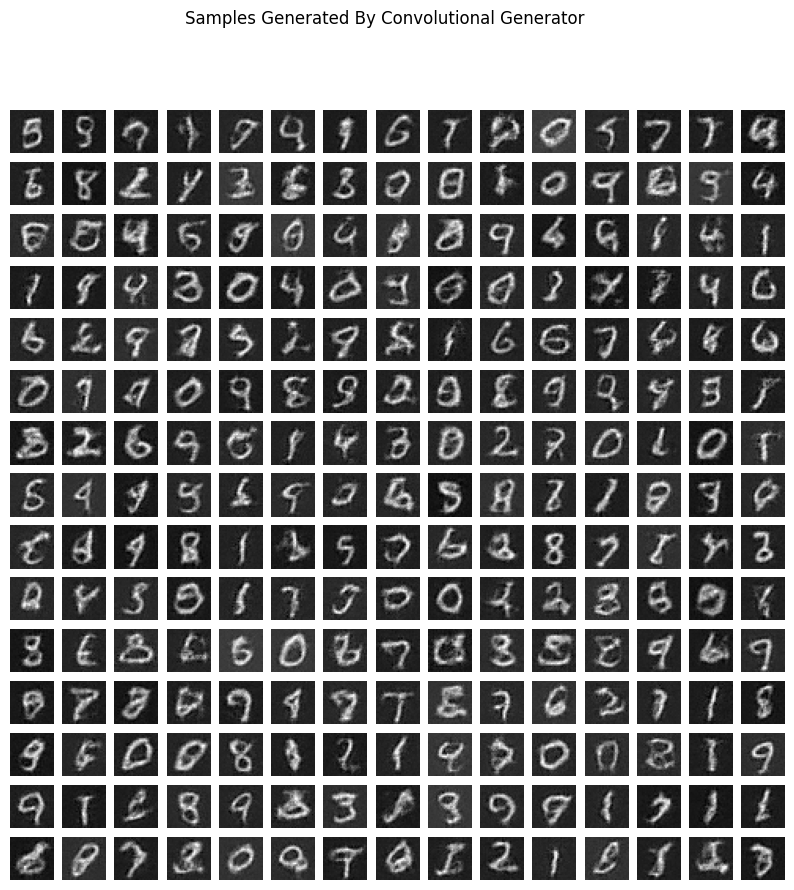

In [15]:
z = torch.randn(512,args['data']['z_features']).to(args['device'])
args['gen']['model'].eval()
with torch.no_grad():
    img = args['gen']['model'](z)
args['gen']['model'].train();

img = img.detach().to('cpu')

fig,axes = plt.subplots(15,15,figsize=(10,10))

fig.suptitle('Samples Generated By Convolutional Generator')

iteration = 0
for i in range(len(axes)):
    for j in range(len(axes)):
        axes[i][j].axis('off')
        axes[i][j].imshow(img[iteration].permute(1,2,0),'gray')
        iteration += 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


dist_fake = critic(img)
img,_ = next(iter(loader))
img = img.to('cuda')
dist_real = critic(img)
dist_fake = dist_fake.detach().squeeze(1).cpu()
dist_real = dist_real.detach().squeeze(1).cpu()


# Plot histograms for both distributions
plt.figure(figsize=(10, 6))

plt.hist(dist_real, bins=30, alpha=0.5, color='blue', label="Real Sample's Distribution")
plt.hist(dist_fake, bins=30, alpha=0.5, color='red', label="Fake Sample's Distribution")

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distributions \n512 Samples Each')
plt.legend()

plt.show()